1. CHARGEMENT ET AUDIT INITIAL DES DONNÉES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Dictionnaire pour stocker tous les dataframes
data_files = {}
load_errors = []

# Fonction pour charger les fichiers avec gestion d'erreurs
def load_file_safe(file_path, file_name, sep=';', encoding='utf-8'):
    """Charge un fichier de manière sécurisée avec plusieurs tentatives"""
    try:
        # CSV 
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        # Excel
        elif file_path.endswith(('.xlsx', '.xls')):
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        
        print(f"✅ {file_name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")
        return df
    except Exception as e:
        print(f"❌ Erreur {file_name}: {e}")
        load_errors.append(f"{file_name}: {e}")
        return None

print("\n🔄 Chargement des fichiers principaux...")

# 1. Employés
employees_df = load_file_safe('data/Employees/employees_table.csv', 'Employés')
if employees_df is not None:
    data_files['employees'] = employees_df

# 2. Réservations
bookings_df = load_file_safe('data/Bookings/Bookings.xlsx', 'Réservations')
if bookings_df is not None:
    data_files['bookings'] = bookings_df

# 3. Clients
customers_df = load_file_safe('data/Customers/customers_extract.xlsx', 'Clients')
if customers_df is not None:
    data_files['customers'] = customers_df
print(customers_df.columns)

# 4. Logs des employés
employee_logs_df = load_file_safe('data/Employee Logs/Employee_Night_Logs.xlsx', 'Logs employés')
if employee_logs_df is not None:
    data_files['employee_logs'] = employee_logs_df

# 5. Planning du bureau
office_schedule_df = load_file_safe('data/Office Schedule/Employee_Evening_Schedule.xlsx', 'Planning bureau')
if office_schedule_df is not None:
    data_files['office_schedule'] = office_schedule_df

# 6. Avis
reviews_df = load_file_safe('data/Reviews/tour_reviews.csv', 'Avis clients')
if reviews_df is not None:
    data_files['reviews'] = reviews_df

# 7. Météo
weather_df = load_file_safe('data/Weather/weather.csv', 'Météo')
if weather_df is not None:
    data_files['weather'] = weather_df
print(weather_df.columns)

# 8. Chargement des logs (tous les sous-dossiers)
print("\n🔄 Chargement des fichiers de logs...")
logs_folders = [
    'Count_Send_Logs',
    'Launch_Logs', 
    'Launchpad_1_Logs',
    'Launchpad_2_Logs',
    'Meeting_Point_Logs',
    'Office_Logs',
    'Return_Logs'
]

logs_data = {}
for folder in logs_folders:
    folder_path = f'data/Logs/{folder}'
    if os.path.exists(folder_path):
        logs_data[folder] = []
        for file in os.listdir(folder_path):
            if file.endswith(('.csv', '.xlsx')):
                file_path = os.path.join(folder_path, file)
                df = load_file_safe(file_path, f'{folder}/{file}')
                if df is not None:
                    df['source_file'] = file
                    df['log_type'] = folder
                    logs_data[folder].append(df)

for i, df in enumerate(logs_data['Meeting_Point_Logs']):
    # split
    if list(df.columns)[0] == 'tag_id,party_id,log_time':
        # Split en 3 colonnes
        new_cols = df['tag_id,party_id,log_time'].str.split(',', expand=True)
        new_cols.columns = ['tag_id', 'party_id', 'log_time']
        # Remplace les colonnes dans le DataFrame
        df = pd.concat([new_cols, df.drop(columns=['tag_id,party_id,log_time'])], axis=1)
        logs_data['Meeting_Point_Logs'][i] = df

for i, df in enumerate(logs_data['Office_Logs']):
    if list(df.columns)[0] == 'tag_id,party_id,log_time':
        new_cols = df['tag_id,party_id,log_time'].str.split(',', expand=True)
        new_cols.columns = ['tag_id', 'party_id', 'log_time']
        df = pd.concat([new_cols, df.drop(columns=['tag_id,party_id,log_time'])], axis=1)
        logs_data['Office_Logs'][i] = df

# 9. Chargement des ventes du bureau
print("\n🔄 Chargement des fichiers de ventes...")
office_sales_data = []
sales_folder = 'data/Office Sales'
if os.path.exists(sales_folder):
    for file in os.listdir(sales_folder):
        if file.endswith(('.csv', '.xlsx')):
            file_path = os.path.join(sales_folder, file)
            df = load_file_safe(file_path, f'Office Sales/{file}')
            if df is not None:
                df['source_file'] = file
                office_sales_data.append(df)


🔄 Chargement des fichiers principaux...
✅ Employés: 23 lignes, 11 colonnes
✅ Réservations: 16 lignes, 7 colonnes
✅ Clients: 1304 lignes, 7 colonnes
Index(['Customerid', 'first_name', 'last_name', 'email', 'gender',
       'nationality', 'Phone'],
      dtype='object')
✅ Logs employés: 7 lignes, 3 colonnes
✅ Planning bureau: 7 lignes, 4 colonnes
✅ Avis clients: 156 lignes, 3 colonnes
✅ Météo: 84 lignes, 5 colonnes
Index(['Day', 'time_of_day', 'weather', 'severity', 'degrees'], dtype='object')

🔄 Chargement des fichiers de logs...
✅ Count_Send_Logs/01-06-2022_night_count_send.csv: 120 lignes, 1 colonnes
✅ Count_Send_Logs/02-06-2022_night_count_send.csv: 130 lignes, 1 colonnes
✅ Count_Send_Logs/03-06-2022_night_count_send.csv: 132 lignes, 1 colonnes
✅ Count_Send_Logs/04-06-2022_night_count_send.csv: 150 lignes, 1 colonnes
✅ Count_Send_Logs/05-06-2022_night_count_send.csv: 149 lignes, 1 colonnes
✅ Count_Send_Logs/06-06-2022_night_count_send.csv: 142 lignes, 1 colonnes
✅ Count_Send_Logs/07

ÉTAPE 1 : AUDIT ET NETTOYAGE DES DONNÉES

In [ ]:

import re


# Consolidation Meeting Point Logs
meeting_point_all = []
for df in logs_data['Meeting_Point_Logs']:
    match = re.search(r'(\d{2}-\d{2}-\d{4})', df['source_file'].iloc[0])
    if match:
        date_str = match.group(1)
        df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    else:
        df['date'] = pd.NaT
    if 'log_time' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['log_time'], errors='coerce')
    else:
        df['timestamp'] = pd.NaT
    df = df.dropna(subset=['timestamp'])
    meeting_point_all.append(df)

meeting_point_df = pd.concat(meeting_point_all, ignore_index=True)
print(f"✅ Meeting Point: {len(meeting_point_df)} enregistrements")

# Consolidation Office Logs
office_all = []
for df in logs_data['Office_Logs']:
    print(df.shape, df.columns, df.head(1))
    if df.empty:
        continue
    file_name = df['source_file'].iloc[0] if 'source_file' in df.columns else None
    if not file_name:
        continue
    date_str = file_name.split('_')[0]
    try:
        df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    except Exception as e:
        print(f"Erreur parsing date pour {file_name}: {e}")
        df['date'] = pd.NaT
    if 'log_time' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['log_time'], errors='coerce')
    else:
        print(" log_time manquant dans Office_Logs")
        df['timestamp'] = pd.NaT
    df = df.dropna(subset=['timestamp'])
    office_all.append(df)


office_df = pd.concat(office_all, ignore_index=True)

print(f"✅ Office: {len(office_df)} enregistrements")
print(office_df[['date', 'timestamp']].head())
print(office_df['date'].unique())


# Consolidation Launch Logs
launch_all = []
for df in logs_data['Launch_Logs']:
    print(df.columns)
    date_str = df['source_file'].iloc[0].split('_')[0]
    df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    df['timestamp'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    launch_all.append(df)

launch_df = pd.concat(launch_all, ignore_index=True)
print(f"✅ Launch: {len(launch_df)} enregistrements")

# Consolidation Return Logs
return_all = []
for df in logs_data['Return_Logs']:
    print(df.columns)
    date_str = df['source_file'].iloc[0].split('_')[0]
    df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    df['timestamp'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    return_all.append(df)

return_df = pd.concat(return_all, ignore_index=True)
print(f"✅ Return: {len(return_df)} enregistrements")

# Regroupe toutes les logs consolidés dans un dictionnaire
consolidated_logs = {
    'meeting_point': meeting_point_df,
    'office': office_df,
    'launch': launch_df,
    'return': return_df
}

# Récupère toutes les dates valides
all_dates_list = []
for df in consolidated_logs.values():
    if 'date' in df.columns and not df.empty:
        all_dates_list.extend(df['date'].dropna().tolist())

if all_dates_list:
    min_date = min(all_dates_list)
    max_date = max(all_dates_list)
    all_dates = pd.date_range(start=min_date, end=max_date)
    master_table = pd.DataFrame({'date': all_dates})
else:
    print(" Aucun log avec une date valide trouvé, master_table vide.")
    master_table = pd.DataFrame({'date': []})

# Agrège les métriques quotidiennes pour chaque type de log
for log_type, df in consolidated_logs.items():
    if 'date' in df.columns:
        if not np.issubdtype(df['date'].dtype, np.datetime64):
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if 'timestamp' in df.columns:
            daily_metrics = df.groupby('date').agg({
                'timestamp': ['count', 'min', 'max']
            }).round(2)
            daily_metrics.columns = [f'{log_type}_{col[1]}' for col in daily_metrics.columns]
            daily_metrics = daily_metrics.reset_index()
            daily_metrics['date'] = pd.to_datetime(daily_metrics['date'], errors='coerce')
            master_table['date'] = pd.to_datetime(master_table['date'], errors='coerce')
            master_table = master_table.merge(daily_metrics, on='date', how='left')
        else:
            print(f" Colonne 'timestamp' absente dans {log_type}")
    else:
        print(f" Colonne 'date' absente dans {log_type}")

print(master_table.head())

# NETTOYAGE 
print("\n🧹 Nettoyage des données clients...")
customers_clean = customers_df.copy()

# Suppression des doublons
customers_clean = customers_clean.drop_duplicates(subset=['Customerid'], keep='first')
print(f"✅ Clients après suppression doublons: {len(customers_clean)}")

# Validation des IDs clients
print("=== IDs CLIENTS ===")

customer_ids = set(data_files['customers']['Customerid'].dropna())
print(f"IDs clients uniques: {len(customer_ids)}")

# Vérifier cohérence avec bookings
if 'bookings' in data_files and 'Customerid' in data_files['bookings'].columns:
    booking_customer_ids = set(data_files['bookings']['Customerid'].dropna())
    missing_customers = booking_customer_ids - customer_ids
    print(f"Clients manquants dans réservations: {len(missing_customers)}")

# Traitement des valeurs manquantes
customers_clean['nationality'] = customers_clean['nationality'].fillna('Unknown')
print(f"✅ Valeurs manquantes traitées")


print("\n Nettoyage des données météo...")
weather_clean = weather_df.copy()
weather_clean['date'] = pd.to_datetime(weather_clean['Day'])
weather_clean = weather_clean.dropna(subset=['degrees', 'weather'])
print(f"✅ Météo nettoyée: {len(weather_clean)} jours")


print("\n Nettoyage des avis clients...")
reviews_clean = reviews_df.copy()
reviews_clean['date'] = pd.to_datetime(reviews_clean['date'])
reviews_clean = reviews_clean.dropna(subset=['rating'])
reviews_clean['rating'] = pd.to_numeric(reviews_clean['rating'], errors='coerce')
reviews_clean = reviews_clean[(reviews_clean['rating'] >= 1) & (reviews_clean['rating'] <= 5)]
print(f"✅ Avis nettoyés: {len(reviews_clean)} avis")


print("\n Consolidation des ventes bureau...")
if office_sales_data:
    office_sales_df = pd.concat(office_sales_data, ignore_index=True)
    office_sales_df['date'] = pd.to_datetime(office_sales_df['date'], errors='coerce')
    office_sales_df = office_sales_df.dropna(subset=['date'])
    print(f"✅ Ventes bureau: {len(office_sales_df)} transactions")
else:
    print(" Pas de données de ventes bureau")

print("\n✅ NETTOYAGE TERMINÉ - Données prêtes pour l'analyse")

print("Colonnes Office_df :", office_df.columns)
print("Extrait Office_df :")
print(office_df.head(10))
print("Dates uniques Office_df :", office_df['date'].unique())
print("Extrait source_file :", office_df['source_file'].unique())

✅ Meeting Point: 2554 enregistrements
(120, 5) Index(['tag_id', 'party_id', 'log_time', 'source_file', 'log_type'], dtype='object')        tag_id                              party_id log_time  \
0  SuLMbNw7hP  25c7c2c6-5803-46b6-b695-d94c15182c8d    17:55   

                   source_file     log_type  
0  01-06-2022_night_office.csv  Office_Logs  
(130, 5) Index(['tag_id', 'party_id', 'log_time', 'source_file', 'log_type'], dtype='object')        tag_id                              party_id log_time  \
0  ncnLbY94WK  6606f337-5839-4658-8453-05e4727615a4    17:58   

                   source_file     log_type  
0  02-06-2022_night_office.csv  Office_Logs  
(132, 5) Index(['tag_id', 'party_id', 'log_time', 'source_file', 'log_type'], dtype='object')        tag_id                              party_id log_time  \
0  WYpoWJVoxk  b13956d1-c15f-4be0-81ee-03566f4b68d2    17:58   

                   source_file     log_type  
0  03-06-2022_night_office.csv  Office_Logs  
(150, 5) Index(['

ÉTAPE 2 : ANALYSE EXPLORATOIRE

In [4]:

print("\n Analyse de la fréquentation par jour...")

# Calcul des participants par jour depuis Meeting Point
daily_attendance = meeting_point_df.groupby('date').size().reset_index(name='participants')
daily_attendance['day_of_week'] = daily_attendance['date'].dt.day_name()
daily_attendance['weekend'] = daily_attendance['day_of_week'].isin(['Saturday', 'Sunday'])

print(" Statistiques de fréquentation:")
print(f"   Moyenne: {daily_attendance['participants'].mean():.1f} participants/jour")
print(f"   Maximum: {daily_attendance['participants'].max()} participants")
print(f"   Minimum: {daily_attendance['participants'].min()} participants")

# Fréquentation par jour de la semaine
freq_by_day = daily_attendance.groupby('day_of_week')['participants'].mean().sort_values(ascending=False)
print(f"\n Fréquentation moyenne par jour:")
for day, avg in freq_by_day.items():
    print(f"   {day}: {avg:.1f} participants")

print("\n Analyse des temps d'attente...")

# Calcul des temps entre Meeting Point et Office
meeting_office_times = []
for date in daily_attendance['date'].unique():
    meeting_times = meeting_point_df[meeting_point_df['date'] == date]['timestamp'].sort_values()
    office_times = office_df[office_df['date'] == date]['timestamp'].sort_values()
    if not meeting_times.empty and not office_times.empty:
        avg_wait = (office_times.iloc[0] - meeting_times.iloc[0]).total_seconds() / 60
        if 0 < avg_wait < 120:
            meeting_office_times.append({'date': date, 'wait_time_minutes': avg_wait})
        else:
            print(f" Attente aberrante pour {date}: {avg_wait} min")
    else:
        print(f" Pas de timestamp pour {date} (meeting: {len(meeting_times)}, office: {len(office_times)})")

wait_times_df = pd.DataFrame(meeting_office_times)
if len(wait_times_df) > 0:
    print(f" Temps d'attente moyen: {wait_times_df['wait_time_minutes'].mean():.1f} minutes")
    print(f"   Maximum: {wait_times_df['wait_time_minutes'].max():.1f} minutes")

# Top nationalités
top_nationalities = customers_clean['nationality'].value_counts().head(5)
print(f"\n Top 5 nationalités:")
for nat, count in top_nationalities.items():
    print(f"   {nat}: {count} ({count/len(customers_clean)*100:.1f}%)")

print("\n Analyse de l'impact météo...")

# Fusion fréquentation et météo
attendance_weather = daily_attendance.merge(weather_clean, on='date', how='inner')

# Fréquentation par condition météo
weather_impact = attendance_weather.groupby('weather')['participants'].agg(['mean', 'count']).round(1)
print(f" Impact météo sur la fréquentation:")
for condition, row in weather_impact.iterrows():
    print(f"   {condition}: {row['mean']} participants (sur {row['count']} jours)")

# Corrélation température-fréquentation
if len(attendance_weather) > 0:
    temp_corr = attendance_weather['degrees'].corr(attendance_weather['participants'])
    print(f"🌡️ Corrélation température-fréquentation: {temp_corr:.3f}")

print("\n Analyse de la satisfaction client...")

# Statistiques des avis
print(f" Avis collectés: {len(reviews_clean)}")
print(f"   Note moyenne: {reviews_clean['rating'].mean():.2f}/5")
print(f"   Médiane: {reviews_clean['rating'].median()}/5")

# Répartition des notes
rating_dist = reviews_clean['rating'].value_counts().sort_index()
print(f"\n Répartition des notes:")
for rating, count in rating_dist.items():
    print(f"   {rating}⭐: {count} avis ({count/len(reviews_clean)*100:.1f}%)")

print("\n✅ ANALYSE EXPLORATOIRE TERMINÉE")



 Analyse de la fréquentation par jour...
 Statistiques de fréquentation:
   Moyenne: 91.2 participants/jour
   Maximum: 171 participants
   Minimum: 8 participants

 Fréquentation moyenne par jour:
   Sunday: 112.0 participants
   Saturday: 108.2 participants
   Friday: 103.2 participants
   Tuesday: 83.2 participants
   Thursday: 80.2 participants
   Wednesday: 78.8 participants
   Monday: 72.8 participants

 Analyse des temps d'attente...
 Temps d'attente moyen: 11.5 minutes
   Maximum: 20.0 minutes

 Top 5 nationalités:
   US: 490 (37.6%)
   CA: 308 (23.6%)
   UK: 209 (16.0%)
   AU: 161 (12.3%)
   DE: 50 (3.8%)

 Analyse de l'impact météo...
 Impact météo sur la fréquentation:
   Clear: 107.5 participants (sur 64.0 jours)
   Rain: 39.2 participants (sur 20.0 jours)
🌡️ Corrélation température-fréquentation: 0.776

 Analyse de la satisfaction client...
 Avis collectés: 156
   Note moyenne: 3.73/5
   Médiane: 4.0/5

 Répartition des notes:
   1⭐: 22 avis (14.1%)
   2⭐: 11 avis (7.1%)


 ÉTAPE 3 : VISUALISATIONS ET INSIGHTS


 Création graphique 1: Évolution de la fréquentation...


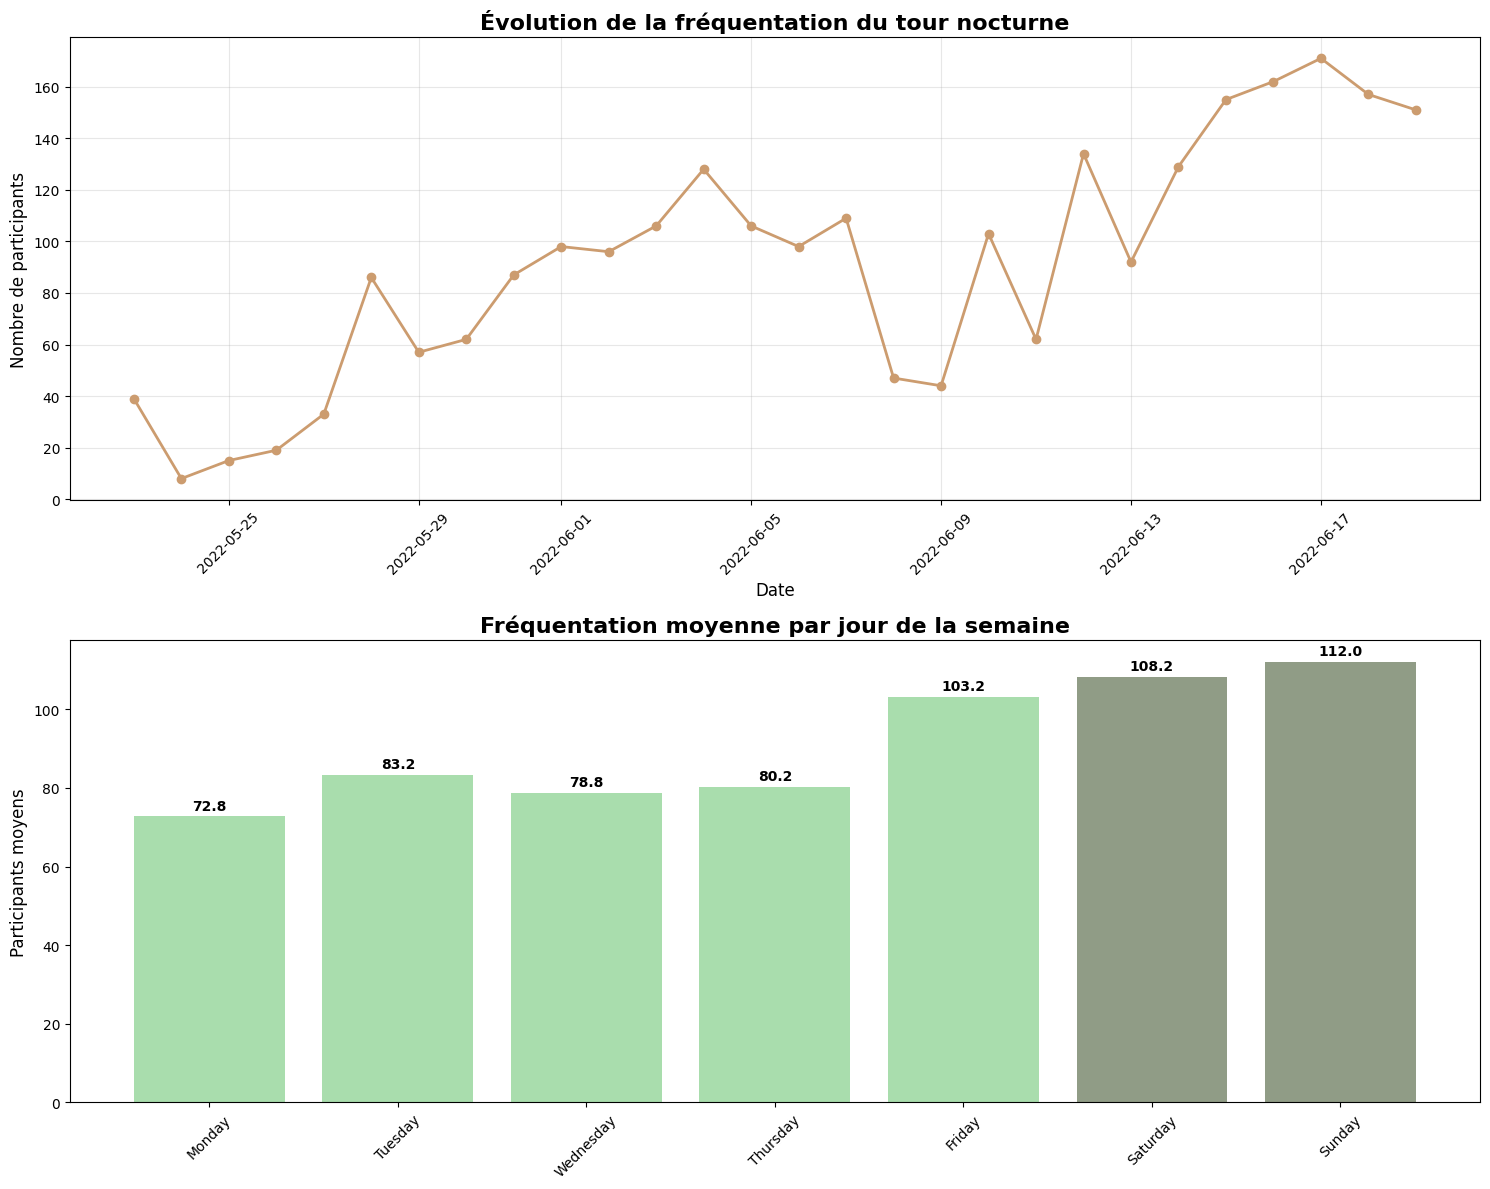


 Création graphique 2: Impact météo et profils clients...


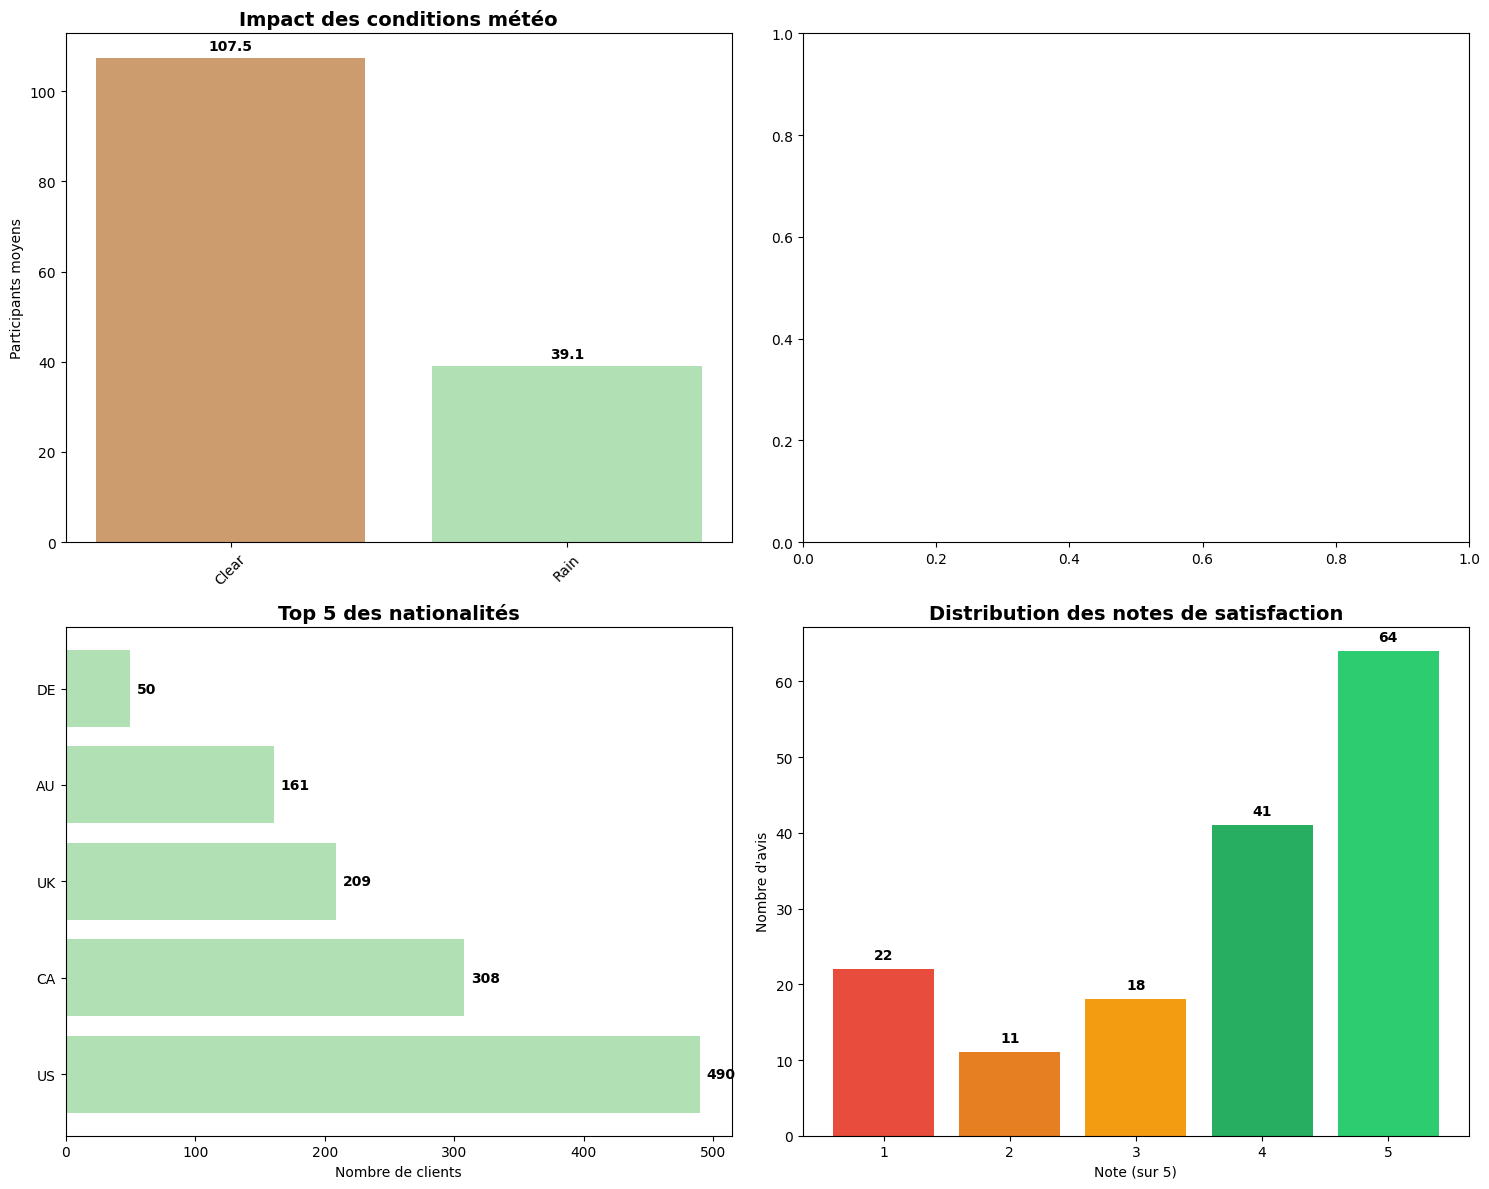


 Création graphique 3: Analyse des flux opérationnels...


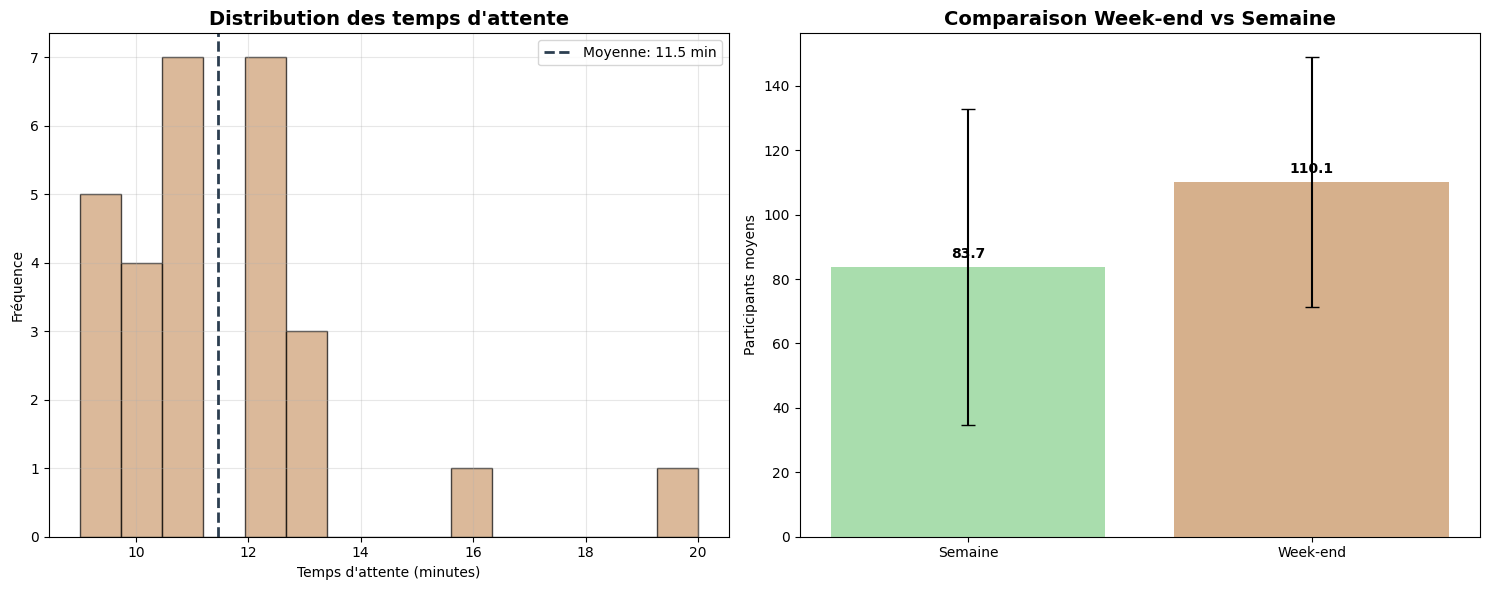


✅ VISUALISATIONS CRÉÉES - Prêt pour les insights business


In [24]:

# Configuration pour les graphiques
plt.rcParams['figure.figsize'] = (15, 10)

print("\n Création graphique 1: Évolution de la fréquentation...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Évolution temporelle
daily_attendance_sorted = daily_attendance.sort_values('date')
ax1.plot(daily_attendance_sorted['date'], daily_attendance_sorted['participants'], 
         marker='o', linewidth=2, markersize=6, color='#CC9C6F')
ax1.set_title('Évolution de la fréquentation du tour nocturne', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Nombre de participants', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Fréquentation par jour de la semaine
freq_by_day_ordered = daily_attendance.groupby('day_of_week')['participants'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
colors = ['#758468' if day in ['Saturday', 'Sunday'] else "#94D599B8" for day in freq_by_day_ordered.index]
bars = ax2.bar(freq_by_day_ordered.index, freq_by_day_ordered.values, color=colors, alpha=0.8)
ax2.set_title('Fréquentation moyenne par jour de la semaine', fontsize=16, fontweight='bold')
ax2.set_ylabel('Participants moyens', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Ajout des valeurs sur les barres
for bar, value in zip(bars, freq_by_day_ordered.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Création graphique 2: Impact météo et profils clients...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Impact météo sur fréquentation
if len(attendance_weather) > 0:
    weather_avg = attendance_weather.groupby('weather')['participants'].mean().sort_values(ascending=False)
    bars1 = ax1.bar(weather_avg.index, weather_avg.values, 
                    color=['#CC9C6F', '#94D599B8', '#D3D3D3'][:len(weather_avg)])
    ax1.set_title('Impact des conditions météo', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Participants moyens')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars1, weather_avg.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Top nationalités
top_5_nat = customers_clean['nationality'].value_counts().head(5)
bars3 = ax3.barh(top_5_nat.index, top_5_nat.values, color='#94D599B8')
ax3.set_title('Top 5 des nationalités', fontsize=14, fontweight='bold')
ax3.set_xlabel('Nombre de clients')

for i, value in enumerate(top_5_nat.values):
    ax3.text(value + 5, i, str(value), va='center', fontweight='bold')

# Satisfaction client
rating_counts = reviews_clean['rating'].value_counts().sort_index()
colors_rating = ['#E74C3C', '#E67E22', '#F39C12', '#27AE60', '#2ECC71']
bars4 = ax4.bar(rating_counts.index, rating_counts.values, 
                color=[colors_rating[int(i)-1] for i in rating_counts.index])
ax4.set_title('Distribution des notes de satisfaction', fontsize=14, fontweight='bold')
ax4.set_xlabel('Note (sur 5)')
ax4.set_ylabel('Nombre d\'avis')

for bar, value in zip(bars4, rating_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Création graphique 3: Analyse des flux opérationnels...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temps d'attente si disponible
if len(wait_times_df) > 0:
    ax1.hist(wait_times_df['wait_time_minutes'], bins=15, color='#CC9C6F', alpha=0.7, edgecolor='black')
    ax1.axvline(wait_times_df['wait_time_minutes'].mean(), color='#2C3E50', 
                linestyle='--', linewidth=2, label=f'Moyenne: {wait_times_df["wait_time_minutes"].mean():.1f} min')
    ax1.set_title('Distribution des temps d\'attente', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Temps d\'attente (minutes)')
    ax1.set_ylabel('Fréquence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Évolution week-end vs semaine
weekend_comparison = daily_attendance.groupby('weekend')['participants'].agg(['mean', 'std'])
categories = ['Semaine', 'Week-end']
means = [weekend_comparison.loc[False, 'mean'], weekend_comparison.loc[True, 'mean']]
stds = [weekend_comparison.loc[False, 'std'], weekend_comparison.loc[True, 'std']]

bars = ax2.bar(categories, means, yerr=stds, capsize=5, 
               color=['#94D599B8', "#CC9C6F"], alpha=0.8)
ax2.set_title('Comparaison Week-end vs Semaine', fontsize=14, fontweight='bold')
ax2.set_ylabel('Participants moyens')

for bar, mean in zip(bars, means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ VISUALISATIONS CRÉÉES - Prêt pour les insights business")


In [7]:
# Export des datasets nettoyés
daily_attendance.to_csv('daily_attendance.csv', index=False)
attendance_weather.to_csv('attendance_weather.csv', index=False)
reviews_clean.to_csv('reviews_clean.csv', index=False)
customers_clean.to_csv('customers_clean.csv', index=False)